In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labor_predictions_log.csv")

In [3]:
df_clean = df.dropna(subset=["Distance", "Labor_Hours"])

In [4]:
df_clean.describe(include="all")

,Name,Size_sqft,Coats,Labor_Hours,Distance,Concurrent_Job,Synthetic
count,30,30.000000,30.000000,30.000000,30.000000,30.000000,30
unique,30,NaN,NaN,NaN,NaN,NaN,1
top,Coppermine,NaN,NaN,NaN,NaN,NaN,N
freq,1,NaN,NaN,NaN,NaN,NaN,30
mean,NaN,8782.500000,1.766667,28.633333,47.166667,0.766667,NaN
std,NaN,2724.537414,0.430183,10.192064,29.975948,0.430183,NaN
min,NaN,6100.000000,1.000000,10.750000,13.000000,0.000000,NaN
25%,NaN,7090.000000,2.000000,22.625000,25.000000,1.000000,NaN
50%,NaN,7896.000000,2.000000,27.250000,36.000000,1.000000,NaN
75%,NaN,10000.000000,2.000000,34.375000,65.500000,1.000000,NaN


In [5]:
df_clean[df_clean["Distance"] > 200]

,Name,Size_sqft,Coats,Labor_Hours,Distance,Concurrent_Job,Synthetic


In [6]:
df_clean.groupby("Coats")["Labor_Hours"].describe()

,count,mean,std,min,25%,50%,75%,max
Coats,,,,,,,,
1.0,7.0,19.285714,7.025888,10.75,15.625,18.0,21.00,33.0
2.0,23.0,31.478261,9.338311,17.50,24.250,29.0,36.25,57.0


In [7]:
df_clean.groupby("Concurrent_Job")["Labor_Hours"].describe()

,count,mean,std,min,25%,50%,75%,max
Concurrent_Job,,,,,,,,
0.0,7.0,28.535714,7.796138,16.25,23.75,29.5,35.00,36.5
1.0,23.0,28.663043,10.970417,10.75,22.75,26.5,33.75,57.0


In [8]:
quartiles = df["Distance"].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
quartiles

array([ 13. ,  25. ,  36. ,  65.5, 107. ])

In [9]:
labels = [f"{int(quartiles[i])}–{int(quartiles[i+1])}" for i in range(len(quartiles)-1)]

In [10]:
df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)

C:\Users\mipo\AppData\Local\Temp\ipykernel_34692\1888029933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)


In [11]:
labor_by_bracket = df_clean.groupby("Distance_Bracket")["Labor_Hours"].mean()
print(labor_by_bracket)

Distance_Bracket
13–25     23.055556
25–36     26.833333
36–65     30.687500
65–107    35.906250
Name: Labor_Hours, dtype: float64


C:\Users\mipo\AppData\Local\Temp\ipykernel_34692\301263866.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labor_by_bracket = df_clean.groupby("Distance_Bracket")["Labor_Hours"].mean()


In [12]:
pivot = df_clean.pivot_table(values="Labor_Hours",
                       index="Coats",
                       columns="Distance_Bracket",
                       aggfunc="mean")
print(pivot)

Distance_Bracket      13–25      25–36  36–65    65–107
Coats                                                  
1.0               19.000000  20.583333  16.25       NaN
2.0               25.083333  29.958333  35.50  35.90625


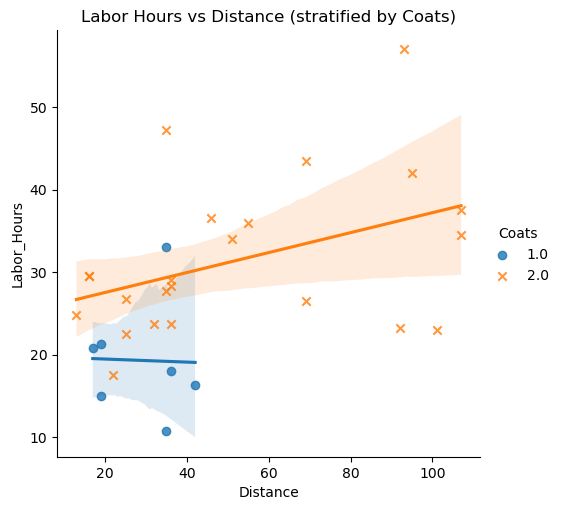

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(data=df_clean, x="Distance", y="Labor_Hours", hue="Coats", markers=["o", "x"])
plt.title("Labor Hours vs Distance (stratified by Coats)")
plt.show()

In [14]:
df_clean.groupby("Synthetic")["Labor_Hours"].describe()

,count,mean,std,min,25%,50%,75%,max
Synthetic,,,,,,,,
N,30.0,28.633333,10.192064,10.75,22.625,27.25,34.375,57.0


In [15]:
df_clean = df.dropna(subset=["Distance", "Labor_Hours", "Coats", "Concurrent_Job"])

In [23]:
# First compute quartiles and labels
quartiles = df_clean["Distance"].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
labels = [f"{int(quartiles[i])}–{int(quartiles[i+1])}" for i in range(len(quartiles)-1)]

# Add bin column to df_clean
df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)

# Now encode everything including the bracket
df_encoded = pd.get_dummies(df_clean, columns=["Distance_Bracket", "Coats", "Concurrent_Job", "Name"], drop_first=True)

C:\Users\mipo\AppData\Local\Temp\ipykernel_34692\397517718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)


In [24]:
X = df_encoded.drop(columns=["Labor_Hours", "Distance"])
y = df_encoded["Labor_Hours"]

In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

ValueError: could not convert string to float: 'N'

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

predictions = model.predict(X)
print("R²:", r2_score(y, predictions))
print("MAE:", mean_absolute_error(y, predictions))